# Building Demand Method 1 Simplified

#### Brief overview:

The energy demand for each cell is assessed according to the following parameters:
𝐵 Number of buildings
𝑆𝑟𝑒𝑠 Share of res buildings
𝑁 Nb of HH per res buildings
𝑎 Electrified status (probability)
𝐸_𝐻𝐻  Energy consumption per HH
𝑟 Adjustment with RWI

For each cell c, we have 𝐷_𝑐=𝐵_𝑐∗𝑆𝑟𝑒𝑠∗𝑁_𝑐  ∗𝑎_𝑐  ∗𝐸_𝐻𝐻  ∗𝑟_𝑐 

### Import necessary modules

In [1]:
# Check if we are running the notebook directly, if so move workspace to parent dir
import sys
import os
currentdir = os.path.abspath(os.getcwd())
if os.path.basename(currentdir) != 'DemandMappingZambia':  
  sys.path.insert(0, os.path.dirname(currentdir))
  os.chdir('..')
  print(f'Move to {os.getcwd()}')

Move to C:\Users\amillot\PycharmProjects\DemandMappingZambia


In [2]:
### Activate geospatial_env first

# Numeric
import numpy as np
import pandas as pd
import math

# System
import shutil
from IPython.display import display, Markdown, HTML, FileLink, FileLinks

# Spatial
import geopandas as gpd
# import json
# import pyproj
# from shapely.geometry import Point, Polygon, MultiPoint
# from shapely.geometry.polygon import Polygon
# from shapely.geometry import shape, mapping
# from shapely.wkt import dumps, loads
# from shapely.ops import nearest_points
# from shapely.ops import unary_union
from pyproj import CRS
# from osgeo import ogr, gdal, osr
# from rasterstats import zonal_stats
# import rasterio
# from geojson import Feature, Point, FeatureCollection
# import rasterio.fill
# import json
# import fiona
# import h3 as h3

# Mapping / Plotting
# from functools import reduce
# import folium
# from folium.features import GeoJsonTooltip
# from folium.plugins import BeautifyIcon
# from folium.plugins import HeatMap
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import LogNorm
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors as colors
# %matplotlib inline

import importlib
import warnings

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
import datetime
# import warnings
# import scipy.spatial
from scipy.optimize import fsolve
warnings.filterwarnings('ignore')

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

pd.options.display.float_format = '{:,.2f}'.format

In [4]:
import config
importlib.reload(config)

<module 'config' from 'C:\\Users\\amillot\\PycharmProjects\\DemandMappingZambia\\config.py'>

In [5]:
from utils import processing_raster, finalizing_rasters, convert_features_to_geodataframe

In [6]:
from Residential.data_loader import load_initial_data, extract_raster_data, load_un_stats, load_census_data

In [7]:
area = config.AREA_OF_INTEREST

## Import data

### Load initial data grid

In [8]:
# Load initial data (grid and administrative boundaries)
regions, admin_gdf, region_gdf, grid = load_initial_data(config)
print(grid.crs)

Loading initial data...
Admin boundaries loaded. Country GDF: (1, 3), Region GDF: (10, 12)
Hexagon grid loaded: (17552, 11)
EPSG:4326


### Extract raster values to hexagons

In [9]:
# Extract raster data
grid = extract_raster_data(grid, config, processing_raster, convert_features_to_geodataframe)
print(grid.crs)

Extracting raster data...
EPSG:4326
2025-06-15 14:19:47.547051
Processed WorldPop Buildings Count.
2025-06-15 14:24:27.092629
Processed WorldPop Urban.
2025-06-15 15:03:04.201434
Processed HREA Lighting.
2025-06-15 15:06:44.267802
Processed RWI.
2025-06-15 15:10:33.968801
Processed Falchetta Tiers (Majority).
2025-06-15 15:14:21.957993
Processed Falchetta Tiers (Mean).
Converting features to GeoDataFrame...
2025-06-15 15:14:24.097616
EPSG:4326
Columns after renaming: Index(['geometry', 'h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchetta_mean'],
      dtype='object')
EPSG:4326
EPSG:4326
EPSG:4326
Finished extracting and processing raster data.
EPSG:4326


### Extract residential and service demand from UN stats

In [10]:
total_residential_elec_GWh, total_services_elec_GWh = load_un_stats(config)

Loading UN energy balance statistics...
Total Residential Energy (UN Stats): 4022 GWh
Total Services Energy (UN Stats): 722 GWh


### Load Census data

In [11]:
data_HH, df_censusdata = load_census_data(config)

Loading census data...
Provincial census data loaded: (11, 11)


## Residential electricity consumption assessment

In [12]:
import Residential.residential_analysis
importlib.reload(Residential.residential_analysis)
from Residential.residential_analysis import determine_location_status, determine_electrification_status, calculate_household_numbers

### Step 1: assess the number of HH with access

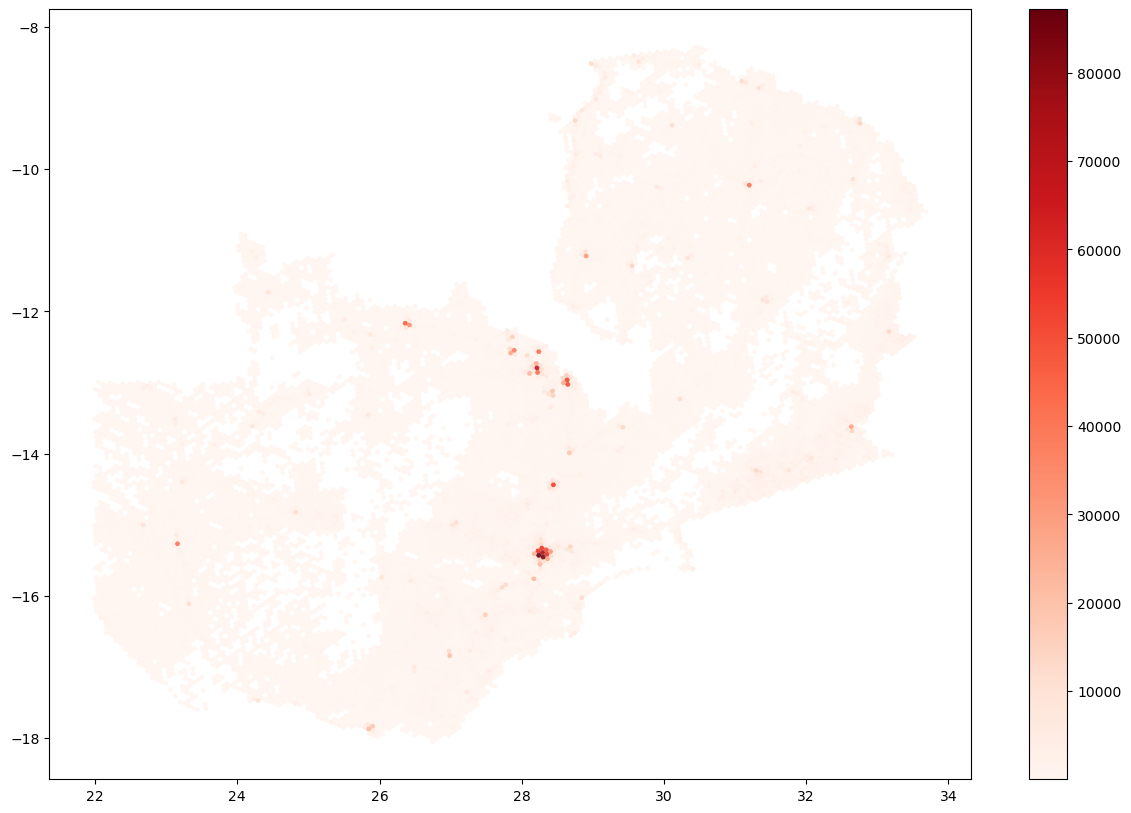

In [13]:
# Plot the buildings map
fig, ax = plt.subplots(figsize=(15, 10))
grid.sort_values('buildingssum', ascending=True).plot(
    ax=ax, column='buildingssum', cmap="Reds", legend=True, alpha=0.9)
ax.set_aspect('equal', 'box')
# txt = ax.set_title('Buildings in {}'.format(area) )

In [14]:
print(grid['buildingssum'].sum())

9186500.0


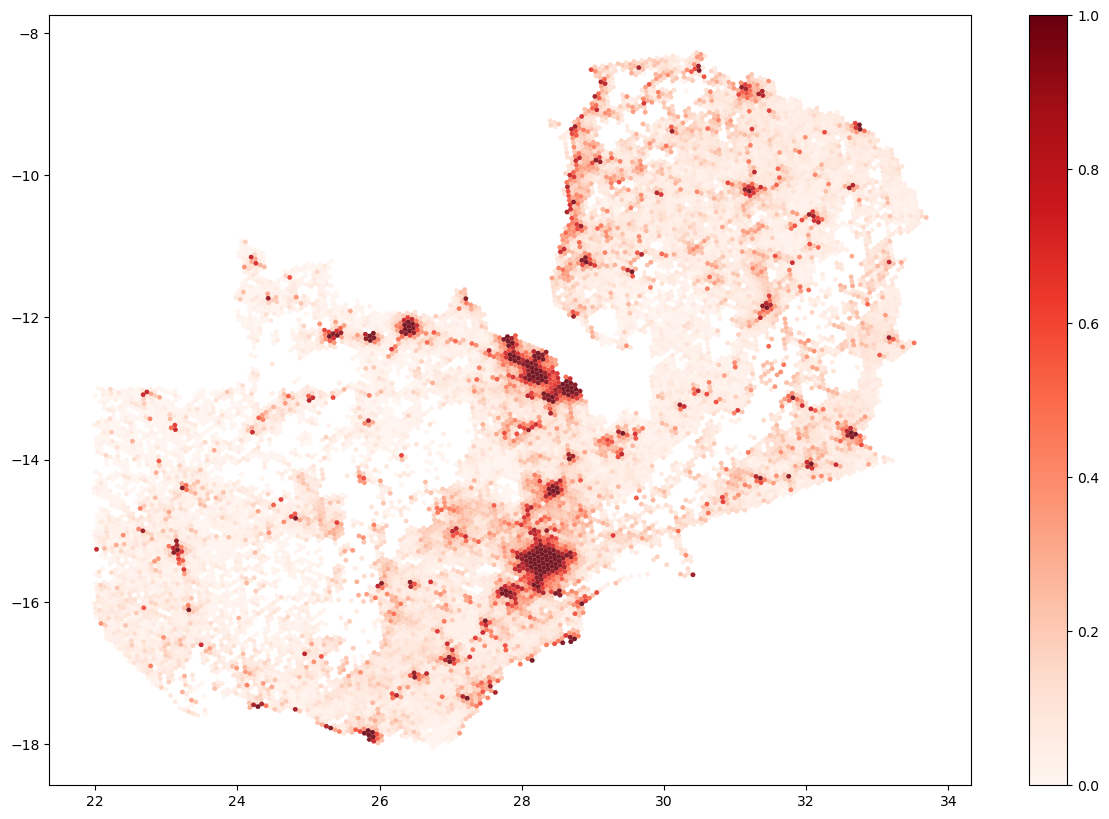

In [15]:
# Plot the lighting map
# Create the axis first
fig, ax = plt.subplots(figsize=(15, 10))

# Filter the data
grid_filtered = grid[(grid['buildingssum'] >= 1000) & (grid['HREA'] <= 0.1)]
grid_filtered = grid[(grid['buildingssum'] >= 2)]
# Plot data
grid_filtered.sort_values('HREA', ascending=True).plot(
    ax=ax, column='HREA', cmap="Reds", legend=True, alpha=0.9)
# # Plot data
# grid.sort_values('buildingssum', ascending=True).plot(
#     ax=ax, column='buildingssum', cmap="Blues", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('HREA in {}'.format(area) )

#### Determine location (ruban or rural) of each cell

In [16]:
grid = determine_location_status(grid, config)

Determining location status (urban/rural)...
'location' column created. Counts: {'rural': 17405, 'urban': 147}


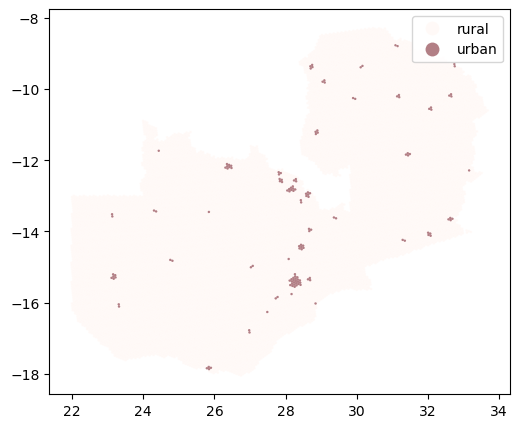

In [17]:
# map of the urban and rural areas WorldPop
fig2, ax2 = plt.subplots(figsize=(10, 5))
grid.sort_values(config.COL_LOC_ASSESSED, ascending=True).plot(
    ax=ax2, column=config.COL_LOC_ASSESSED, cmap="Reds", legend=True, alpha=0.5)
ax2.set_aspect('equal', 'box')
# txt = ax2.set_title('Urban and rural areas WorldPop in {} '.format(area))

#### Determine electrifed status of each cell

In [18]:
grid = determine_electrification_status(grid, config, admin_gdf)

Determining electrification status...
--- Initial Data Sanity Check ---
Grid CRS: EPSG:4326 | Shape: (17552, 18)
Admin Boundary CRS: EPSG:4326 | Shape: (1, 3)
MV Lines CRS: EPSG:4326 | Shape: (64868, 49)
HV Lines CRS: EPSG:4326 | Shape: (931, 63)
Target CRS for all operations: EPSG:32735

--- Projecting all data to target CRS ---
Processing proximity for HV Lines with buffer 500m...
Processing proximity for MV Lines with buffer 500m...
Updated 'is_near_any_line' column. Current counts:
is_near_any_line
False    14679
True      2873
Name: count, dtype: int64
'Status_electrified' column created. Counts: {'nonelec': 15523, 'elec': 2029}


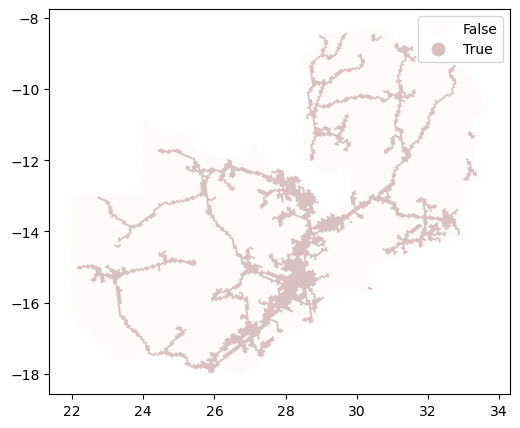

In [19]:
# map of the lines
fig3, ax3 = plt.subplots(figsize=(10, 5))
grid.sort_values('is_near_any_line', ascending=True).plot(
    ax=ax3, column='is_near_any_line', cmap="Reds", legend=True, alpha=0.25)
ax3.set_aspect('equal', 'box')
# lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)
# txt = ax3.set_title('Lines {} '.format(area))

#### Assess number of households per cell

In [20]:
grid, df_HH_buildings = calculate_household_numbers(grid, config, data_HH, regions)

Calculating household numbers...
Total population calculated: 17,798,700
Finished calculating household numbers.


In [21]:
df_HH_buildings

,HH_urban,HH_rural,size_HH_urban,size_HH_rural,HH_total,totalBuildings,urbanBuildings,ruralBuildings,shareRuralBuild,shareUrbanBuild,shareUrbanResBui,shareRuralResBui,resUrbanBui,resRuralBui,resTotalBui
region,,,,,,,,,,,,,,,
Copperbelt,"449,077.00","85,356.00",4.66,5.13,"534,433.00","1,040,660.00","574,556.00","466,104.00",0.45,0.55,0.71,0.18,"408,251.82","85,356.00","493,607.82"
Muchinga,"24,953.00","151,730.00",4.30,4.73,"176,683.00","573,784.00","83,532.00","490,252.00",0.85,0.15,0.27,0.31,"22,684.55","151,730.00","174,414.55"
North-Western,"91,501.00","116,233.00",5.03,5.53,"207,734.00","517,799.00","146,182.00","371,617.00",0.72,0.28,0.57,0.31,"83,182.73","116,233.00","199,415.73"
Western,"54,466.00","205,604.00",4.47,4.92,"260,070.00","751,165.00","81,720.00","669,445.00",0.89,0.11,0.61,0.31,"49,514.55","205,604.00","255,118.55"
Luapula,"44,689.00","228,300.00",4.72,5.19,"272,989.00","583,700.00","82,797.00","500,903.00",0.86,0.14,0.49,0.46,"40,626.36","228,300.00","268,926.36"
Northern,"72,867.00","230,684.00",4.58,5.04,"303,551.00","728,186.00","96,378.00","631,808.00",0.87,0.13,0.69,0.37,"66,242.73","230,684.00","296,926.73"
Central,"98,493.00","292,947.00",4.75,5.22,"391,440.00","1,293,182.00","214,889.00","1,078,293.00",0.83,0.17,0.42,0.27,"89,539.09","292,947.00","382,486.09"
Southern,"120,410.00","316,294.00",4.66,5.13,"436,704.00","1,303,679.00","128,001.00","1,175,678.00",0.90,0.10,0.86,0.27,"109,463.64","316,294.00","425,757.64"
Eastern,"82,166.00","369,725.00",4.68,5.15,"451,891.00","1,285,025.00","118,608.00","1,166,417.00",0.91,0.09,0.63,0.32,"74,696.36","369,725.00","444,421.36"


#### Assess number of households per cell with access to electricity

In [22]:
def estimate_hh_with_access(grid_gdf, app_config, df_HH_buildings, data_HH):
    """
    Estimates the number of households with electricity access and calculates access rates.

    Updates grid_gdf with columns for households with and without access.
    If provincial data is available,
    this DataFrame is updated with regional access summaries and saved to a CSV.

    Args:
        grid_gdf: GeoDataFrame of the hexagonal grid.
        app_config: The configuration module.
        df_HH_buildings: DataFrame for regional household summaries.

    Returns:
        tuple: (grid_gdf, df_HH_buildings)
               - grid_gdf: Updated grid GeoDataFrame.
               - df_HH_buildings: Updated regional summary DataFrame (or None).
    """
    print("Estimating households with access...")

    # Ensure required columns exist
    required_cols = [app_config.COL_HH_URBAN, app_config.COL_HH_RURAL, 
                     app_config.PROB_ELEC_COL, app_config.COL_STATUS_ELECTRIFIED]
    for col in required_cols:
        if col not in grid_gdf.columns:
            raise KeyError(f"Required column '{col}' not found in grid_gdf for HH access calculation.")

    grid_gdf[app_config.COL_HH_WITH_ACCESS_URB] = (
        grid_gdf[app_config.COL_HH_URBAN] *
        grid_gdf[app_config.PROB_ELEC_COL] *
        (grid_gdf[app_config.COL_STATUS_ELECTRIFIED] == 'elec') *
        app_config.CORRECTION_FACTOR_URBAN_HH_ACCESS
    )
    grid_gdf[app_config.COL_HH_WITH_ACCESS_RUR] = (
        grid_gdf[app_config.COL_HH_RURAL] *
        grid_gdf[app_config.PROB_ELEC_COL] *
        (grid_gdf[app_config.COL_STATUS_ELECTRIFIED] == 'elec')
    )
    grid_gdf[app_config.COL_HH_WITH_ACCESS] = grid_gdf[app_config.COL_HH_WITH_ACCESS_URB] + grid_gdf[app_config.COL_HH_WITH_ACCESS_RUR]
    
    # HH without access
    grid_gdf[app_config.COL_HH_WO_ACCESS_URB] = grid_gdf[app_config.COL_HH_URBAN] - grid_gdf[app_config.COL_HH_WITH_ACCESS_URB]
    grid_gdf[app_config.COL_HH_WO_ACCESS_RUR] = grid_gdf[app_config.COL_HH_RURAL] - grid_gdf[app_config.COL_HH_WITH_ACCESS_RUR]
    grid_gdf[app_config.COL_HH_WO_ACCESS] = grid_gdf[app_config.COL_HH_WO_ACCESS_URB] + grid_gdf[app_config.COL_HH_WO_ACCESS_RUR]

    if app_config.PROVINCE_DATA_AVAILABLE and df_HH_buildings is not None:
        print("Aggregating HH access data by region...")
        # Aggregate HH with access by region
        totalHHWithAccessUrb = grid_gdf.groupby(app_config.COL_ADMIN_NAME)[app_config.COL_HH_WITH_ACCESS_URB].sum()
        totalHHWithAccessRur = grid_gdf.groupby(app_config.COL_ADMIN_NAME)[app_config.COL_HH_WITH_ACCESS_RUR].sum()
        totalHHWithAccess = grid_gdf.groupby(app_config.COL_ADMIN_NAME)[app_config.COL_HH_WITH_ACCESS].sum()

        df_HH_access_summary = pd.DataFrame({
            app_config.COL_HH_WITH_ACCESS_URB: totalHHWithAccessUrb,
            app_config.COL_HH_WITH_ACCESS_RUR: totalHHWithAccessRur,
            app_config.COL_HH_WITH_ACCESS: totalHHWithAccess,
        })
        df_HH_access_summary.rename_axis('region', inplace=True)
        # Merge with df_HH_buildings
        df_HH_buildings = df_HH_buildings.merge(df_HH_access_summary, left_index=True, right_index=True)
        
        # Calculate population with access (requires df_censusdata for HH size)
        # This part might be better placed if df_censusdata is passed directly, or HH size is already in df_HH_buildings_optional
        if app_config.COL_POPULATION in grid_gdf.columns: # Check if population was calculated
            get_size_HH = lambda row: data_HH.loc[row[app_config.COL_ADMIN_NAME], f"size_HH_{row[app_config.COL_LOC_ASSESSED]}"] \
                                  if row[app_config.COL_ADMIN_NAME] in data_HH.index else np.nan
            grid_gdf['population_urban_withAccess'] = grid_gdf[app_config.COL_POPULATION] * grid_gdf.apply(get_size_HH, axis=1).replace([np.inf, -np.inf, np.nan], 0)
            grid_gdf['population_rural_withAccess'] = grid_gdf[app_config.COL_POPULATION] * grid_gdf.apply(get_size_HH, axis=1).replace([np.inf, -np.inf, np.nan], 0)
            grid_gdf['population_withAccess'] = grid_gdf['population_urban_withAccess'] + grid_gdf['population_rural_withAccess']
            total_population_withAccess = grid_gdf['population_withAccess'].sum()
            print(f"Total population with access (estimated): {total_population_withAccess:,.0f}")
        
        # Calculate access rates in df_HH_buildings
        df_HH_buildings['accessRateHH'] = (df_HH_buildings[app_config.COL_HH_WITH_ACCESS] / df_HH_buildings['HH_total']).replace([np.inf, -np.inf, np.nan], 0)
        df_HH_buildings['accessRateHH_urban'] = (df_HH_buildings[app_config.COL_HH_WITH_ACCESS_URB] / df_HH_buildings['HH_urban']).replace([np.inf, -np.inf, np.nan], 0)
        df_HH_buildings['accessRateHH_rural'] = (df_HH_buildings[app_config.COL_HH_WITH_ACCESS_RUR] / df_HH_buildings['HH_rural']).replace([np.inf, -np.inf, np.nan], 0)
        
        # Add national summary to df_HH_buildings
        if not df_HH_buildings.empty:
            df_sum = df_HH_buildings[[col for col in df_HH_buildings.columns if col != app_config.COL_ADMIN_NAME]].sum(axis=0, numeric_only=True)
            df_sum[app_config.COL_ADMIN_NAME] = 'National'
            # Recalculate rates for National summary
            df_sum['accessRateHH'] = df_sum[app_config.COL_HH_WITH_ACCESS] / df_sum['HH_total']
            df_sum['accessRateHH_urban'] = df_sum[app_config.COL_HH_WITH_ACCESS_URB] / df_sum['HH_urban']
            df_sum['accessRateHH_rural'] = df_sum[app_config.COL_HH_WITH_ACCESS_RUR] / df_sum['HH_rural']
            df_sum = pd.DataFrame(df_sum).T.set_index(app_config.COL_ADMIN_NAME)
            df_HH_buildings = pd.concat([df_HH_buildings, df_sum])

        output_csv_path = os.path.join(app_config.RESIDENTIAL_OUTPUT_DIR, "dataHH_region.csv")
        df_HH_buildings.to_csv(output_csv_path, index=True)
        print(f"Regional HH summary saved to {output_csv_path}")
        print(df_HH_buildings[['accessRateHH','accessRateHH_urban','accessRateHH_rural']].tail())


    print("Finished estimating households with access.")
    return grid_gdf, df_HH_buildings

In [23]:
grid, df_HH_buildings = estimate_hh_with_access(grid, config, df_HH_buildings, data_HH)

Estimating households with access...
Aggregating HH access data by region...
Total population with access (estimated): 173,667,846
Regional HH summary saved to C:\Users\amillot\PycharmProjects\DemandMappingZambia\Residential\Outputs\dataHH_region.csv
         accessRateHH accessRateHH_urban accessRateHH_rural
Central          0.31               0.74               0.16
Southern         0.39               0.99               0.16
Eastern          0.23               0.73               0.12
Lusaka           0.90               1.00               0.42
National         0.49               0.92               0.17
Finished estimating households with access.


### Step 2: assess the electricity consumption per HH

#### Method 1: link the energy consumption to rwi through a logistic function

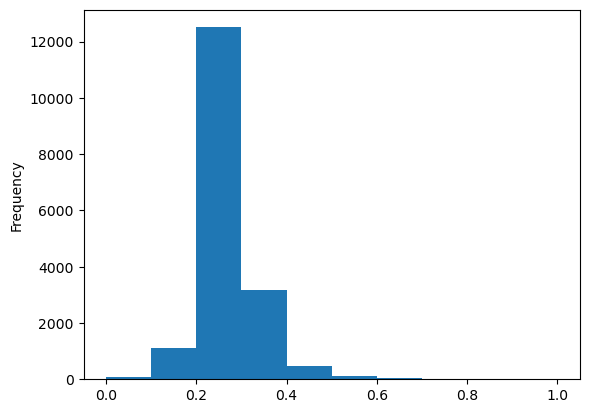

In [24]:
# Normalise the rwi index
rwi_min = grid['rwi'].min()
rwi_max = grid['rwi'].max()
grid['rwi_norm'] = (grid['rwi'] - rwi_min) / (rwi_max - rwi_min)
grid['rwi_norm'].plot.hist()
plt.show()

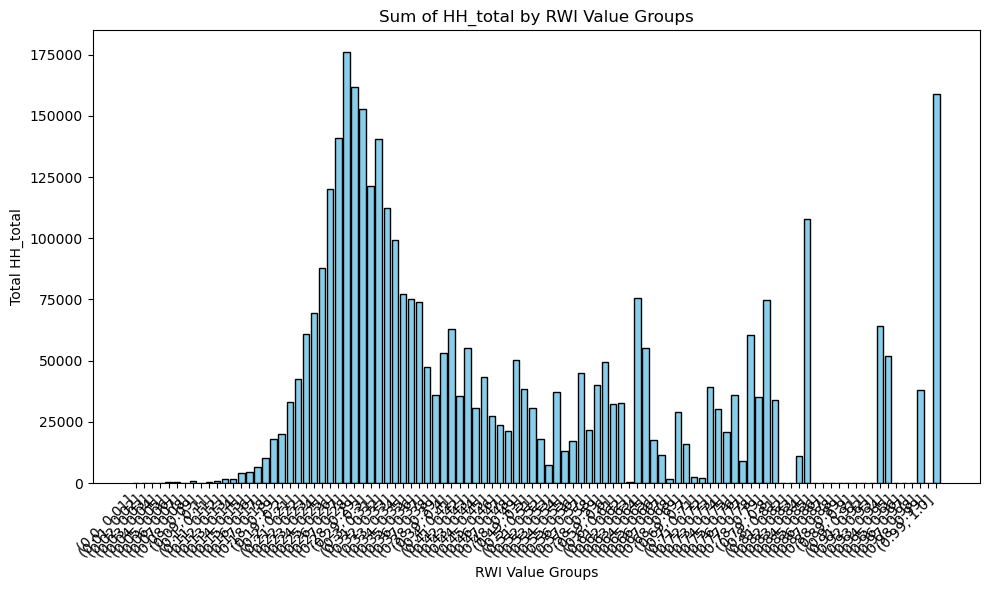

In [25]:
# Plot of number of HH vs rwi

# Create equally spaced bins for the 'rwi' values
num_groups = 100
min_rwi = grid['rwi_norm'].min()
max_rwi = grid['rwi_norm'].max()
bin_width = (max_rwi - min_rwi) / num_groups
rwi_bins = [min_rwi + i * bin_width for i in range(num_groups + 1)]
rwi_bins_labels = [(rwi_bins[i] + rwi_bins[i])/2 for i in range(num_groups)]

# Group by the bins and sum the 'HH_total' values
grid['rwi_group'] = pd.cut(grid['rwi_norm'], rwi_bins)
result = grid.groupby('rwi_group')['HH_total'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
# plt.bar(rwi_bins_labels, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH_total')
plt.title('Sum of HH_total by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

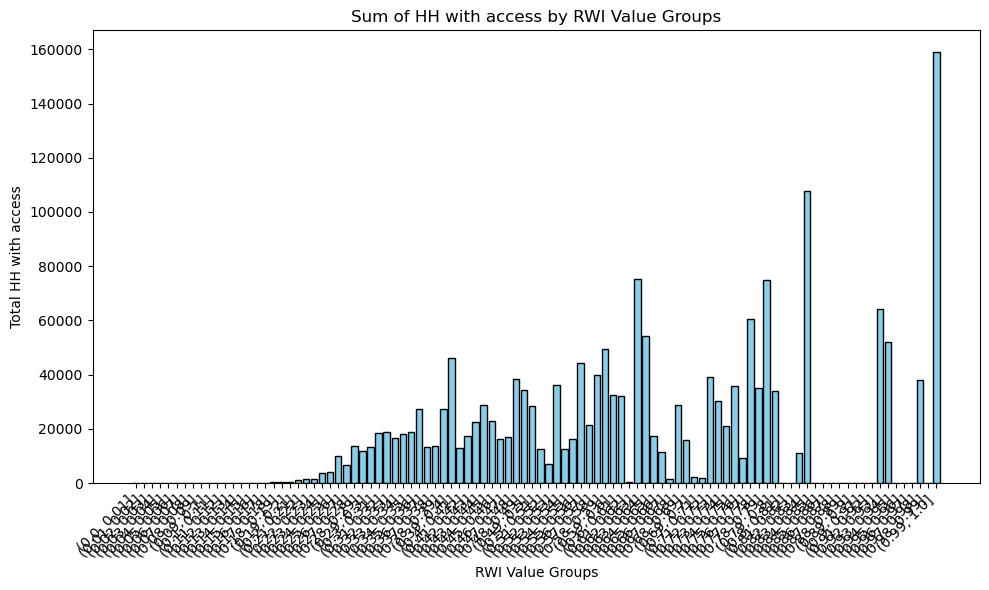

In [26]:
# Plot of number of HH with access vs rwi

# Group by the bins and sum the 'HHwithAccess' values
result = grid.groupby('rwi_group')['HHwithAccess'].sum()
result.index = result.index.astype(str)
# # Print the result
# print(result)

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(result.index, result.values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Total HH with access')
plt.title('Sum of HH with access by RWI Value Groups')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [27]:
def calculate_energy_per_hh_method1(grid_gdf, app_config, total_residential_elec_GWh):
    """
    Calculates energy per household using RWI-based logistic function

    This method normalizes the Relative Wealth Index (RWI), then solves for a 
    parameter `k` in a logistic function to ensure the total calculated energy 
    matches UN statistics. It adds a column for the calculated energy per household.

    Args:
        grid_gdf: GeoDataFrame of the hexagonal grid.
        app_config: The configuration module.
        total_residential_energy_gwh: Total national residential energy (GWh) from UN stats.

    Returns:
        GeoDataFrame: grid_gdf with added column for energy per household (Method 1).
    """
    print("Calculating energy per HH (Method 1: RWI-logistic)...")
    
    if app_config.COL_RWI_MEAN not in grid_gdf.columns:
        raise KeyError(f"Required column '{app_config.COL_RWI_MEAN}' not found for RWI normalization.")

    rwi_min = grid_gdf[app_config.COL_RWI_MEAN].min()
    rwi_max = grid_gdf[app_config.COL_RWI_MEAN].max()
    if (rwi_max - rwi_min) == 0: 
        grid_gdf[app_config.COL_RWI_NORM] = 0.5 
        print("Warning: RWI min and max are equal. Normalized RWI set to 0.5.")
    else:
        grid_gdf[app_config.COL_RWI_NORM] = (grid_gdf[app_config.COL_RWI_MEAN] - rwi_min) / (rwi_max - rwi_min)

    alpha = app_config.LOGISTIC_E_THRESHOLD / app_config.LOGISTIC_ALPHA_DERIVATION_THRESHOLD - 1
    
    if app_config.COL_HH_WITH_ACCESS not in grid_gdf.columns:
        raise KeyError(f"Required column '{app_config.COL_HH_WITH_ACCESS}' not found for fsolve.")

    def func_solve_k(k_var):
        # Calculates total energy based on k_var and compares to UN total.
        e_hh = app_config.LOGISTIC_E_THRESHOLD / (1 + alpha * np.exp(-k_var * grid_gdf[app_config.COL_RWI_NORM]))
        res_energy_assessed = (e_hh * grid_gdf[app_config.COL_HH_WITH_ACCESS]).sum()
        return res_energy_assessed / 1e6 - total_residential_elec_GWh # kWh to GWh

    try:
        k_solution = fsolve(func_solve_k, app_config.LOGISTIC_K_INITIAL_GUESS)
        # print(f"Solved k for logistic function: {k_solution[0]:.4f}")
        k_to_use = k_solution[0]
    except Exception as e:
        print(f"Error solving for k in RWI-logistic method: {e}. Using initial guess: {app_config.LOGISTIC_K_INITIAL_GUESS}")
        k_to_use = app_config.LOGISTIC_K_INITIAL_GUESS
        
    grid_gdf[app_config.COL_RES_ELEC_PER_HH_LOG] = app_config.LOGISTIC_E_THRESHOLD / (
        1 + alpha * np.exp(-k_to_use * grid_gdf[app_config.COL_RWI_NORM])
    )
    print("Finished calculating energy per HH (Method 1).")
    return grid_gdf, k_to_use

In [28]:
grid, k_to_use = calculate_energy_per_hh_method1(grid, config, total_residential_elec_GWh)

Calculating energy per HH (Method 1: RWI-logistic)...
Finished calculating energy per HH (Method 1).


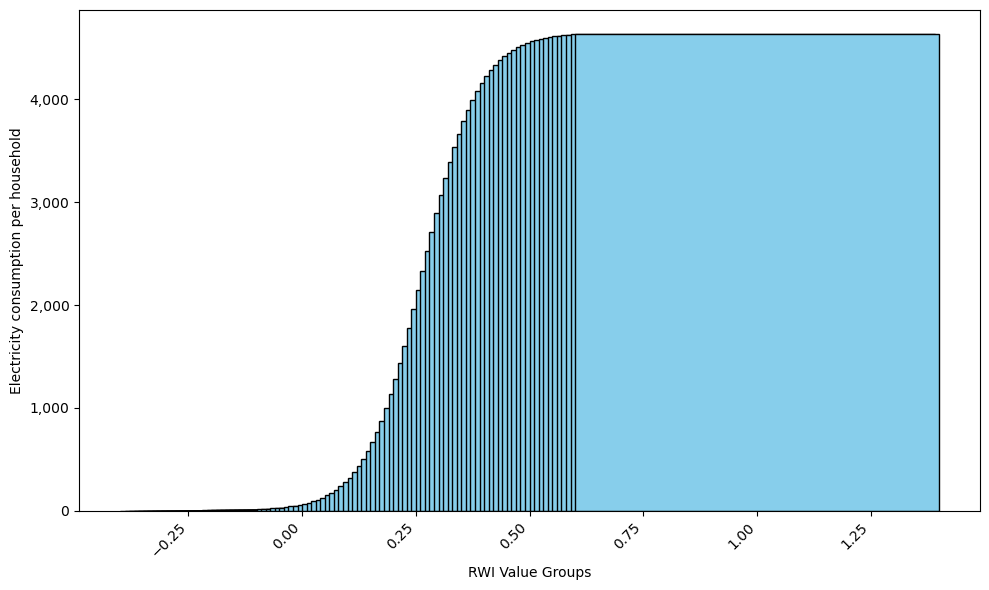

In [29]:
# create the curve linking energy consumption per HH and rwi
rwi_values = rwi_bins # rwi value groups
k = k_to_use  # Adjust this constant for the desired curve steepness
E_threshold = config.LOGISTIC_E_THRESHOLD
alpha = config.LOGISTIC_E_THRESHOLD / config.LOGISTIC_ALPHA_DERIVATION_THRESHOLD - 1
E_HH_values = config.LOGISTIC_E_THRESHOLD / (1 + alpha * np.exp(-k * np.array(rwi_values)))
# print(E_threshold / (1 + alpha * np.exp(-k  * 0)))
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(rwi_values, E_HH_values, color='skyblue', edgecolor='black')
plt.xlabel('RWI Value Groups')
plt.ylabel('Electricity consumption per household')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with logistic relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

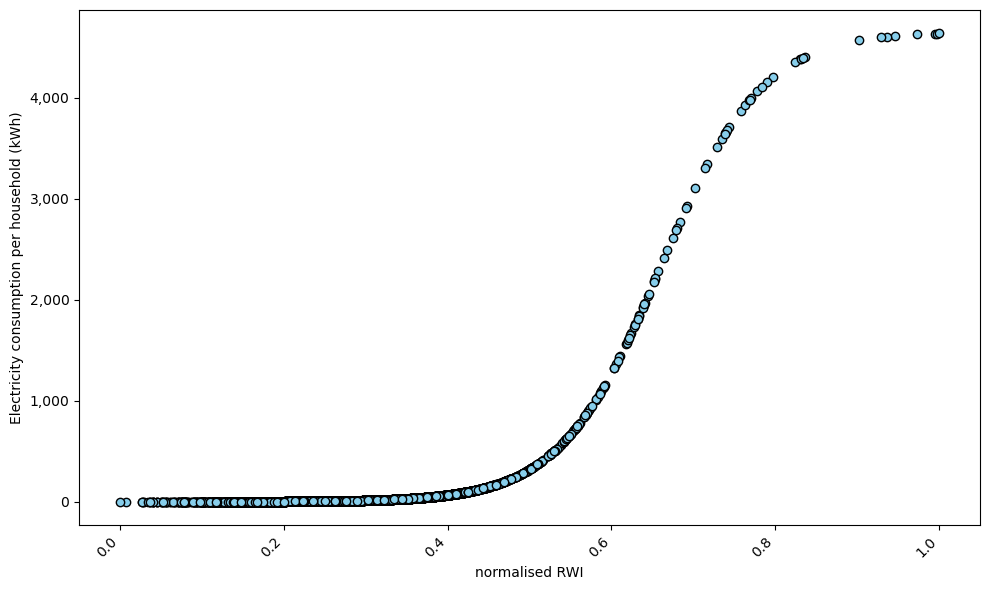

In [30]:
# check that total energy assessed matches the statistics
grid['ResEnergyPerHH_log'] = E_threshold / (1 + alpha * np.exp(-k * grid['rwi_norm']))

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.scatter(grid['rwi_norm'], grid['ResEnergyPerHH_log'], color='skyblue', edgecolor='black')
plt.xlabel('normalised RWI')
plt.ylabel('Electricity consumption per household (kWh)')
ax = plt.gca()  # Get the current axis
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
# plt.title('Energy vs. RWI with Logarithmic Relationship')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Method 2: use data coming from the DHS survey

In [31]:
def calculate_energy_per_hh_method2(grid_gdf, app_config, estimate_energy_func):
    """
    Calculates energy per household using Method 2 (DHS survey-based).

    This method calls an external script (`estimate_energy_rwi_link_national`)
    which processes DHS data to link RWI and electricity access to electricity consumption.

    Args:
        grid_gdf: GeoDataFrame of the hexagonal grid.
        app_config: The configuration module.
        estimate_energy_func: The imported `estimate_energy_rwi_link_national` function.

    Returns:
        GeoDataFrame: grid_gdf with added column for electricity per household (Method 2).
    """
    print("Calculating energy per HH (Method 2: DHS-based)...")
    
    dhs_survey_folder = os.path.join(app_config.RESIDENTIAL_DATA_PATH, "DHSSurvey/")
    
    grid_gdf = estimate_energy_func(
        grid_gdf,
        dhs_survey_folder, 
        app_config.FIGURES_DHS_FOLDER, 
        make_figure=app_config.DHS_MAKE_FIGURE,
        recalculate_energies=app_config.DHS_RECALCULATE_ENERGIES,
        simulate_cell_groups=app_config.DHS_SIMULATE_CELL_GROUPS,
        recalculate_energy_perhh=app_config.DHS_RECALCULATE_ENERGY_PERHH
    )
    
    col_elec_rural = 'elec_demand_kWh_rural' 
    col_elec_urban = 'elec_demand_kWh_urban' 
    
    if col_elec_rural not in grid_gdf.columns or col_elec_urban not in grid_gdf.columns:
        raise KeyError(f"Expected columns '{col_elec_rural}' or '{col_elec_urban}' not found after DHS estimation.")
        
    grid_gdf[app_config.COL_RES_ELEC_PER_HH_DHS] = grid_gdf[col_elec_rural] + grid_gdf[col_elec_urban]
    
    print("Finished calculating energy per HH (Method 2).")
    return grid_gdf

Calculating energy per HH (Method 2: DHS-based)...
urban total = 2,972 GWh/year
urban average per household = 2,062 kWh/year
urban min = 0 kWh/year max = 2,944 kWh/year
Created rwi_vs_energy_use_urban.png


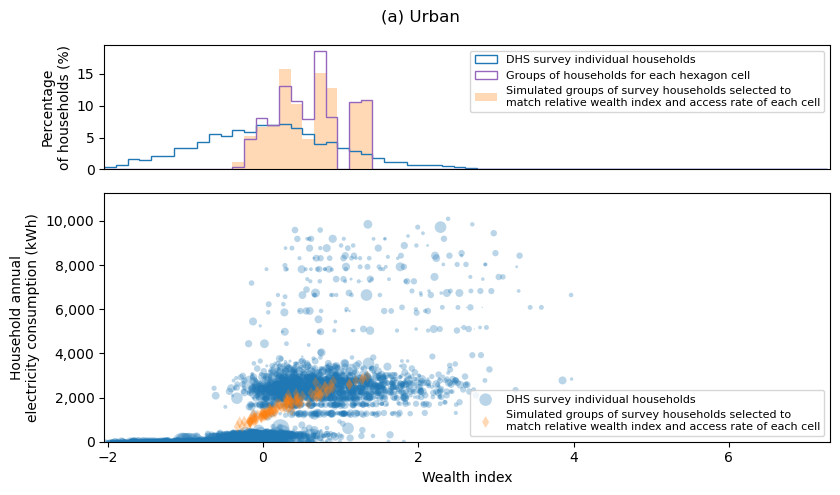

rural total = 27 GWh/year
rural average per household = 73 kWh/year
rural min = 0 kWh/year max = 790 kWh/year
Created rwi_vs_energy_use_rural.png


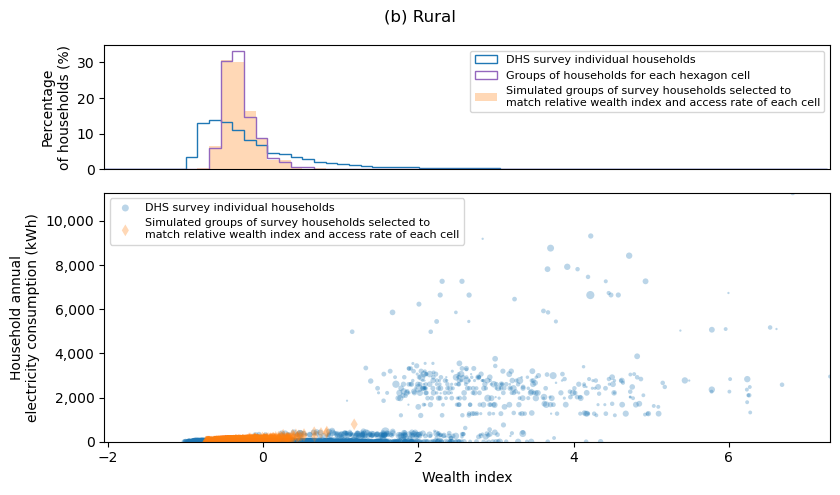

Finished calculating energy per HH (Method 2).


In [32]:
import Residential.HouseholdEnergyUse.estimate_energy_rwi_link_national_new

# 1. Reload the entire module file
importlib.reload(Residential.HouseholdEnergyUse.estimate_energy_rwi_link_national_new)

# 2. After reloading, re-import the specific function to get the updated version
from Residential.HouseholdEnergyUse.estimate_energy_rwi_link_national_new import estimate_energy_rwi_link_national
grid = calculate_energy_per_hh_method2(grid, config, estimate_energy_rwi_link_national)

### Step 3: assess electricity consumption per cell

In [33]:
def calculate_total_residential_electricity(grid_gdf, app_config, total_residential_energy_gwh):
    """
    Calculates total residential energy per cell for different methods and scales to UN stats.

    This function takes the per-household energy estimates from Method 1 (RWI-logistic)
    and Method 2 (DHS-based), calculates the total energy per grid cell for each method,
    and then scales these totals so that the national aggregate matches UN statistics.

    Args:
        grid_gdf: GeoDataFrame of the hexagonal grid with per-HH energy estimates.
        app_config: The configuration module.
        total_residential_energy_gwh: Total national residential energy (GWh) from UN stats.

    Returns:
        GeoDataFrame: grid_gdf with added columns for raw and scaled total residential energy.
    """
    print("Calculating total residential energy and scaling...")

    # Ensure required input columns exist
    required_cols_meth1 = [app_config.COL_RES_ELEC_PER_HH_LOG, app_config.COL_HH_WITH_ACCESS]
    required_cols_meth2 = [app_config.COL_RES_ELEC_PER_HH_DHS, app_config.COL_HH_WITH_ACCESS]
    
    for col in required_cols_meth1:
        if col not in grid_gdf.columns: raise KeyError(f"Method 1: Column '{col}' not found.")
    for col in required_cols_meth2:
        if col not in grid_gdf.columns: raise KeyError(f"Method 2: Column '{col}' not found.")

    # For method 1, assign electricity per HH where access > 0, else 0
    grid_gdf["ElecPerHH_kWh_meth1"] = grid_gdf.apply(
        lambda row: row[app_config.COL_RES_ELEC_PER_HH_LOG] if row[app_config.COL_HH_WITH_ACCESS] > 0 else 0, axis=1
    )
    # For method 2, the ElectricityPerHH_DHS is already calculated considering access within its script.
    grid_gdf["ElecPerHH_kWh_meth2"] = grid_gdf[app_config.COL_RES_ELEC_PER_HH_DHS]

    methods_map = {
        'meth1': {'per_hh_col': "ElecPerHH_kWh_meth1", 'output_col_scaled': app_config.COL_RES_ELEC_KWH_METH1_SCALED, 'raw_total_col': app_config.COL_RES_ELEC_KWH_METH1},
        'meth2': {'per_hh_col': "ElecPerHH_kWh_meth2", 'output_col_scaled': app_config.COL_RES_ELEC_KWH_METH2_SCALED, 'raw_total_col': app_config.COL_RES_ELEC_KWH_METH2}
    }

    results_beforescaling_summary = {}
    results_afterscaling_summary = {}

    for method_key, details in methods_map.items():
        # Calculate raw total energy per cell (kWh)
        grid_gdf[details['raw_total_col']] = grid_gdf[app_config.COL_HH_WITH_ACCESS] * grid_gdf[details['per_hh_col']]
        
        # Aggregate by administrative region (e.g., NAME_1) if COL_ADMIN_NAME is present
        if app_config.COL_ADMIN_NAME in grid_gdf.columns:
            regional_sum_gwh = grid_gdf.groupby(app_config.COL_ADMIN_NAME)[details['raw_total_col']].sum() / 10**6 # kWh to GWh
            results_beforescaling_summary[method_key] = regional_sum_gwh
            total_assessed_gwh = regional_sum_gwh.sum()
        else: # No admin column, sum all cells
            total_assessed_gwh = grid_gdf[details['raw_total_col']].sum() / 10**6 # kWh to GWh
            results_beforescaling_summary[method_key] = pd.Series({"National": total_assessed_gwh})


        if total_assessed_gwh == 0:
            print(f"Warning: Total assessed energy for {method_key} is 0. Scaling factor cannot be computed. Scaled energy will be 0.")
            scaling_factor = 0
        else:
            scaling_factor = total_residential_energy_gwh / total_assessed_gwh
        
        print(f"Method {method_key}: Total Assessed = {total_assessed_gwh:.2f} GWh, UN Stats = {total_residential_energy_gwh:.2f} GWh, Scaling Factor = {scaling_factor:.4f}")

        grid_gdf[details['output_col_scaled']] = grid_gdf[details['raw_total_col']] * scaling_factor
        
        if app_config.COL_ADMIN_NAME in grid_gdf.columns:
            results_afterscaling_summary[method_key] = grid_gdf.groupby(app_config.COL_ADMIN_NAME)[details['output_col_scaled']].sum() / 10**6
        else:
            results_afterscaling_summary[method_key] = pd.Series({"National": grid_gdf[details['output_col_scaled']].sum() / 10**6})

    print("\nSummary of energy consumption before scaling (GWh):")
    print(pd.DataFrame(results_beforescaling_summary))
    print("\nSummary of energy consumption after scaling (GWh):")
    print(pd.DataFrame(results_afterscaling_summary))
    
    print("Finished calculating and scaling total residential energy.")
    return grid_gdf

In [34]:
grid = calculate_total_residential_electricity(grid, config, total_residential_elec_GWh)

Calculating total residential energy and scaling...
Method meth1: Total Assessed = 4022.50 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.0000
Method meth2: Total Assessed = 2974.92 GWh, UN Stats = 4022.50 GWh, Scaling Factor = 1.3521

Summary of energy consumption before scaling (GWh):
                 meth1    meth2
NAME_1                         
Central         128.91   128.96
Copperbelt    1,377.40   960.59
Eastern          43.13    83.31
Luapula          10.78    45.66
Lusaka        2,029.70 1,275.75
Muchinga          2.52    11.37
North-Western   132.79   120.89
Northern         45.93    78.34
Southern        216.58   203.68
Western          34.77    66.36

Summary of energy consumption after scaling (GWh):
                 meth1    meth2
NAME_1                         
Central         128.91   174.37
Copperbelt    1,377.40 1,298.86
Eastern          43.13   112.64
Luapula          10.78    61.74
Lusaka        2,029.70 1,724.99
Muchinga          2.52    15.38
North-Western   132

### Compare access rates to Falchetta dataset

In [35]:
def compare_access_to_falchetta(grid_gdf, app_config):
    """
    Compares calculated residential energy consumption tiers with Falchetta dataset tiers.

    This function bins calculated per-household energy into tiers and compares the 
    distribution of households across these tiers against pre-loaded Falchetta tier data.
    It also performs a similarity analysis between the DHS-based calculated tiers and 
    Falchetta's majority tier.

    Args:
        grid_gdf: GeoDataFrame of the hexagonal grid with energy consumption data.
        app_config: The configuration module.

    Returns:
        GeoDataFrame: grid_gdf, potentially with added columns for tiering/comparison.
    """
    print("Comparing access tiers to Falchetta dataset...")

    def calculate_tier_share_method(data_grid, method_suffix, hh_with_access_col, hh_wo_access_col, category_total_val):
        # Helper for tier share calculation
        tier_col_name = f'tiers_{method_suffix}' 
        if tier_col_name not in data_grid.columns:
            # print(f"Warning: Tier column '{tier_col_name}' not found for method '{method_suffix}'.")
            return pd.Series(dtype=float)
        if category_total_val == 0: return pd.Series(dtype=float)

        tier_share = data_grid.groupby(tier_col_name)[hh_with_access_col].sum()
        if 0 in tier_share.index :
            tier_share.loc[0] += data_grid[hh_wo_access_col].sum()
        else: 
            tier_share.loc[0] = data_grid[hh_wo_access_col].sum()
        return tier_share.sort_index() / category_total_val

    bins_tiers = app_config.BINS_TIERS_ENERGY
    tier_labels = range(len(bins_tiers) - 1)

    categories_summary = {
        'national': app_config.COL_HH_TOTAL, 'urban': app_config.COL_HH_URBAN, 'rural': app_config.COL_HH_RURAL
    }

    # Falchetta dataset
    for col_type in [app_config.COL_TIERS_FALCHETTA_MAJ, app_config.COL_TIERS_FALCHETTA_MEAN]:
        if col_type in grid_gdf.columns:
            tiers_summary_df = pd.DataFrame()
            for cat_name, total_hh_col in categories_summary.items():
                 if total_hh_col in grid_gdf.columns and grid_gdf[total_hh_col].sum() > 0:
                    cat_sum = grid_gdf.groupby(col_type)[total_hh_col].sum()
                    tiers_summary_df[cat_name] = cat_sum / cat_sum.sum()
            print(f"\nFalchetta Tiers Summary ({col_type}):")
            print(tiers_summary_df.fillna(0))
    
    # Our methods
    methods_to_compare = {
        'meth1': app_config.COL_RES_ELEC_PER_HH_LOG,
        'meth2': "ElecPerHH_kWh_meth2" 
    }
    categories_for_comparison = [
        ('national', app_config.COL_HH_WITH_ACCESS, app_config.COL_HH_WO_ACCESS, app_config.COL_HH_TOTAL),
        ('urban', app_config.COL_HH_WITH_ACCESS_URB, app_config.COL_HH_WO_ACCESS_URB, app_config.COL_HH_URBAN),
        ('rural', app_config.COL_HH_WITH_ACCESS_RUR, app_config.COL_HH_WO_ACCESS_RUR, app_config.COL_HH_RURAL)
    ]

    for method_key, energy_col_name in methods_to_compare.items():
        if energy_col_name not in grid_gdf.columns:
            print(f"Warning: Energy column '{energy_col_name}' for method '{method_key}' not found.")
            continue
        
        grid_gdf[f'tiers_{method_key}'] = pd.cut(grid_gdf[energy_col_name], bins=bins_tiers, labels=tier_labels, right=False)
        grid_gdf[f'tiers_{method_key}'] = grid_gdf[f'tiers_{method_key}'].fillna(0).astype(int)

        df_tiers_data = pd.DataFrame()
        for cat_name, hh_access_col, hh_no_access_col, total_hh_col in categories_for_comparison:
            if all(c in grid_gdf.columns for c in [hh_access_col, hh_no_access_col, total_hh_col]):
                cat_total_val = grid_gdf[total_hh_col].sum()
                if cat_total_val > 0:
                    tier_share_series = calculate_tier_share_method(grid_gdf, method_key, hh_access_col, hh_no_access_col, cat_total_val)
                    df_tiers_data[cat_name] = tier_share_series
        
        print(f"\nTier Shares for Method '{method_key}':")
        print(df_tiers_data.fillna(0))

    if f'tiers_meth2' in grid_gdf.columns and app_config.COL_TIERS_FALCHETTA_MAJ in grid_gdf.columns:
        grid_gdf['tiers_DHS_adjusted'] = grid_gdf['tiers_meth2'].where(grid_gdf['tiers_meth2'] != 5, 4) 
        grid_gdf['Similarity_Falchetta_DHS'] = grid_gdf['tiers_DHS_adjusted'] == grid_gdf[app_config.COL_TIERS_FALCHETTA_MAJ]
        grid_gdf['Difference_Falchetta_DHS'] = abs(pd.to_numeric(grid_gdf['tiers_DHS_adjusted']) - pd.to_numeric(grid_gdf[app_config.COL_TIERS_FALCHETTA_MAJ]))

        print("\nSimilarity Analysis (Falchetta vs DHS-Method2):")
        print(f"Number of lines with similar tiers: {grid_gdf['Similarity_Falchetta_DHS'].sum()}")
        print(f"Mean difference in tiers: {grid_gdf['Difference_Falchetta_DHS'].mean():.2f}")
        print(f"Median difference in tiers: {grid_gdf['Difference_Falchetta_DHS'].median():.2f}")
    
    print("Finished Falchetta comparison.")
    return grid_gdf

In [36]:
grid = compare_access_to_falchetta(grid, config)

Comparing access tiers to Falchetta dataset...

Falchetta Tiers Summary (tiers_falchetta_maj):
                     national  urban  rural
tiers_falchetta_maj                        
0.00                     0.65   0.20   0.98
1.00                     0.00   0.00   0.00
2.00                     0.01   0.01   0.01
3.00                     0.00   0.00   0.00
4.00                     0.34   0.79   0.01

Falchetta Tiers Summary (tiers_falchetta_mean):
                      national  urban  rural
tiers_falchetta_mean                        
0                         0.53   0.02   0.91
1                         0.07   0.09   0.05
2                         0.08   0.15   0.02
3                         0.07   0.16   0.01
4                         0.25   0.58   0.00

Tier Shares for Method 'meth1':
             national  urban  rural
tiers_meth1                        
0                0.51   0.08   0.84
1                0.07   0.03   0.10
2                0.07   0.10   0.04
3                0.0

### Final grid

In [37]:
print(grid.columns)
grid.to_csv(config.RESIDENTIAL_OUTPUT_DIR / 'data_res.csv')

Index(['geometry', 'h3_index', 'n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'index',
       'NAME_1', 'id', 'buildingssum', 'locationWP', 'HREA', 'rwi',
       'tiers_falchetta_maj', 'tiers_falchetta_mean', 'location',
       'is_near_any_line', 'Status_electrified', 'res_urbanBui',
       'res_ruralBui', 'res_Bui', 'HH_urban', 'HH_rural', 'HH_total',
       'pop_urban', 'pop_rural', 'pop_total', 'HHwithAccess_urb',
       'HHwithAccess_rur', 'HHwithAccess', 'HHwoAccess_urb', 'HHwoAccess_rur',
       'HHwoAccess', 'population_urban_withAccess',
       'population_rural_withAccess', 'population_withAccess', 'rwi_norm',
       'rwi_group', 'Elec_PerHH_kWh_log', 'ResEnergyPerHH_log',
       'Simulated group rwi urban', 'elec_demand_kWh_urban',
       'Simulated group rwi rural', 'elec_demand_kWh_rural',
       'Elec_PerHH_kWh_DHS', 'ElecPerHH_kWh_meth1', 'ElecPerHH_kWh_meth2',
       'Elec_kWh_meth1', 'ResElec_kWh_meth1_scaled', 'Elec_kWh_meth2',
       'ResElec_kWh_meth2_scaled', 'tiers_meth1', '

In [38]:
if 'rwi_group' in grid.columns:
    grid = grid.drop('rwi_group', axis=1)
if 'tiers_DHS' in grid.columns:
    grid = grid.drop('tiers_DHS', axis=1)
if 'bin_labels' in grid.columns:
    grid = grid.drop('bin_labels', axis=1)
grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / 'res_energy_map.shp', index=False)
grid.head(3)

,geometry,h3_index,n0,n1,n2,n3,n4,n5,index,NAME_1,...,ElecPerHH_kWh_meth2,Elec_kWh_meth1,ResElec_kWh_meth1_scaled,Elec_kWh_meth2,ResElec_kWh_meth2_scaled,tiers_meth1,tiers_meth2,tiers_DHS_adjusted,Similarity_Falchetta_DHS,Difference_Falchetta_DHS
0,"POLYGON ((30.15835 -11.49771, 30.12117 -11.502...",869611b9fffffff,5433,5705,1736,4522,2006,16376,0,Luapula,...,0.00,0.00,0.00,0.00,0.00,1,0,0,True,0.00
1,"POLYGON ((25.80651 -14.77118, 25.76884 -14.775...",86962959fffffff,5100,1836,13758,599,16897,2151,1,Central,...,0.00,0.00,0.00,0.00,0.00,1,0,0,True,0.00
2,"POLYGON ((28.05537 -12.75045, 28.01795 -12.755...",8696014cfffffff,6083,15822,3066,16340,7159,13504,2,Copperbelt,...,46.31,"3,517.33","3,517.33","3,757.85","5,081.14",1,1,1,True,0.00


### Map residential results

In [39]:
resultRes = 'ResElec_kWh_meth2_scaled'
grid[resultRes] = grid[resultRes]/10**6

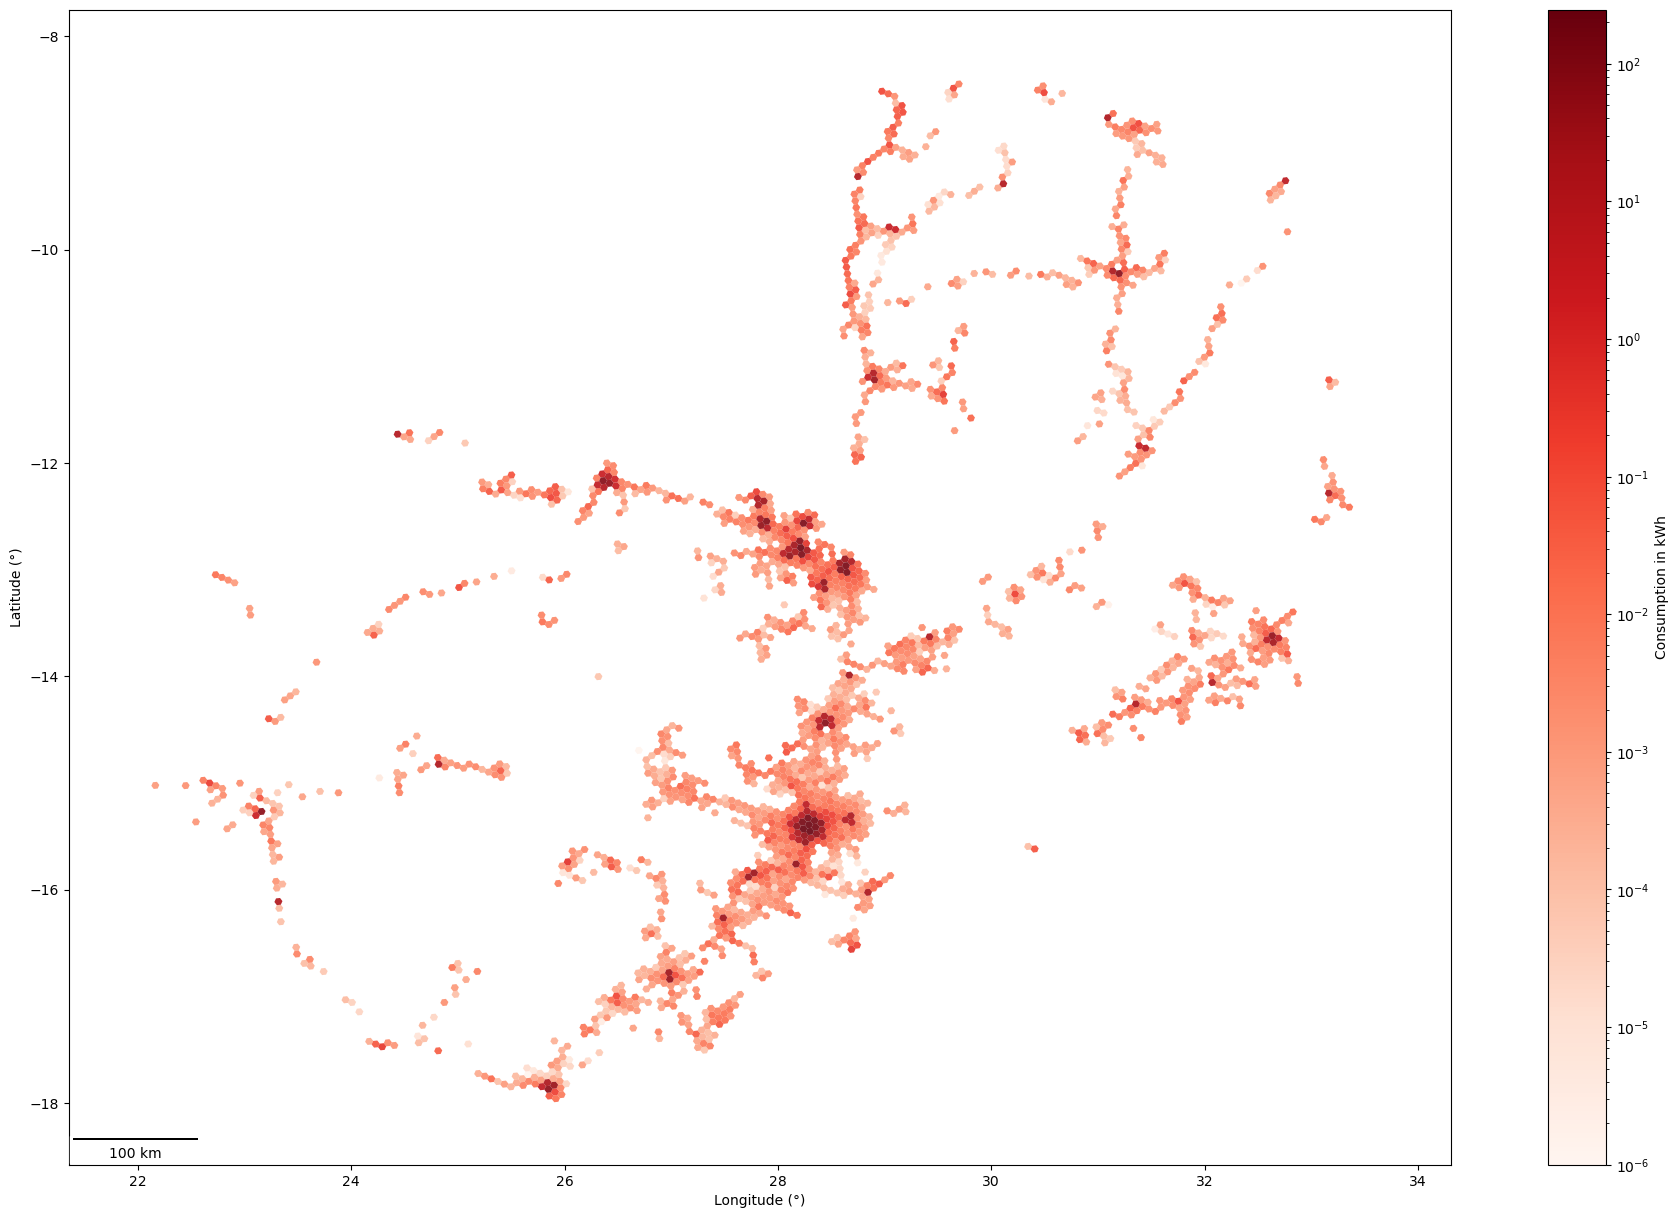

In [40]:
# Plot the demand map with a log scale value
# Create the axis first
# sns.set_theme('poster')
# sns.set_style('white')
fig, ax = plt.subplots(figsize=(25, 15))

# Add latitude and longitude labels
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

# Plot data
grid.sort_values(resultRes, ascending=True).plot(
    ax=ax, column=resultRes, cmap="Reds", legend=True, alpha=0.9, norm=colors.LogNorm(vmin = 1e-6, vmax=grid[resultRes].max()),
    legend_kwds={"label": "Consumption in kWh"}) #, "orientation": "horizontal"})

# admin_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.6)
# region_gdf.plot(ax=ax, edgecolor='brown', color='None', alpha=0.2)
# transmission lines
# lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.4)
# MV_lines_gdf.plot(ax=ax, edgecolor='purple', color='purple', alpha=0.05)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Electricity consumption in the residential sector in {} (kWh)'.format(area) )
# txt = ax.set_title('Electricity consumption in the residential sector (kWh)' )

# print(grid.crs)

# Compute the distance-per-pixel of the map
# see https://geopandas.org/en/latest/gallery/matplotlib_scalebar.html#Geographic-coordinate-system-(degrees)
# assert grid.crs == 'EPSG:4326'
from shapely.geometry.point import Point
points = gpd.GeoSeries(
    [Point(-73.5, 40.5), Point(-74.5, 40.5)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(32619)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

# Add a scale bar
scalebar = ScaleBar(
    distance_meters,
    dimension="si-length",
    location='lower left',
    length_fraction=0.1,
    width_fraction=0.001,
    units='m',
    color='black',
    fixed_value=None
)

ax.add_artist(scalebar)

# Save plot as figure 
plt.savefig(config.RESIDENTIAL_OUTPUT_DIR / 'map_res_log.png', bbox_inches='tight')

# Services

In [48]:
import Residential.service_analysis
importlib.reload(Residential.service_analysis)
from Residential.service_analysis import calculate_service_buildings_based_elec, calculate_service_gdp_based_elec, calculate_employee_based_electricity

## Electricity consumption based on number of buildings with access

In [42]:
grid = calculate_service_buildings_based_elec(grid, config, total_services_elec_GWh)

Calculating services electricity (building-based)...
Total services buildings with estimated access: 2,027,615
Service electricity per accessible building: 356 kWh/building
Finished calculating services electricity (building-based).


## Energy consumption based on GDP

In [43]:
# grid = calculate_service_gdp_based_elec(grid, config, total_services_elec_GWh)

## Energy consumption based on employees

In [49]:
grid = calculate_employee_based_electricity(grid, config, total_services_elec_GWh, df_censusdata)

Calculating services energy (employee-based)...
  Calculating number of men and women (15-49)...
  Calculating number of working men and women...
Total employees with access: 2,028,477
Service electricity per accessible employee: 355.77 kWh/employee
Finished calculating services energy (employee-based).


## Weighted average of the three assessements

In [51]:
# if config.COL_GDP_PPP_MEAN in grid.columns:
#     # Link between buildings and GDP
#     plt.scatter(grid['serBUi_Acc'], grid['GDP_PPP'],s=1)
    
#     # Add labels to the plot
#     plt.xlabel('serBUi_Acc')
#     plt.ylabel('GDP_PPP')
    
#     # Set the axis to logarithmic scale
#     # plt.yscale('log')
#     # plt.xscale('log')
    
#     # Show the plot
#     plt.show()

In [52]:
threshold_access = 0.1 # lower value than residential because easier to connect services buildings
alpha = config.SERVICES_WEIGHT_GDP
beta = config.SERVICES_WEIGHT_BUILDINGS
gama = config.SERVICES_WEIGHT_EMPLOYEES

In [53]:
# compute weighted average
# Create a boolean Series indicating if probElec meets the condition
# condition_met = grid[probElec] >= threshold_access
# Assign the weighted average based on the condition
grid['SElec_kWh_weighted'] = (beta * grid[config.COL_SER_ELEC_KWH_BUI] + gama * grid[config.COL_SER_ELEC_KWH_EMP] )

totalSEn_kWh_weighted = grid['SElec_kWh_weighted'].sum()
grid[config.COL_SER_ELEC_KWH_FINAL] = grid['SElec_kWh_weighted'] / totalSEn_kWh_weighted * total_services_elec_GWh *10**6 

## Results per region and map

In [54]:
services_result = pd.DataFrame()
services_result = grid.groupby('NAME_1')[config.COL_SER_ELEC_KWH_FINAL].sum() / 10**6 # conversion in GWh
pd.options.display.float_format = '{:.2f}'.format
services_result

NAME_1
Central          49.11
Copperbelt      195.54
Eastern          46.38
Luapula          28.75
Lusaka          236.10
Muchinga          6.34
North-Western    37.70
Northern         25.10
Southern         72.98
Western          23.68
Name: Ser_elec_kWh_final, dtype: float64

NameError: name 'out_path' is not defined

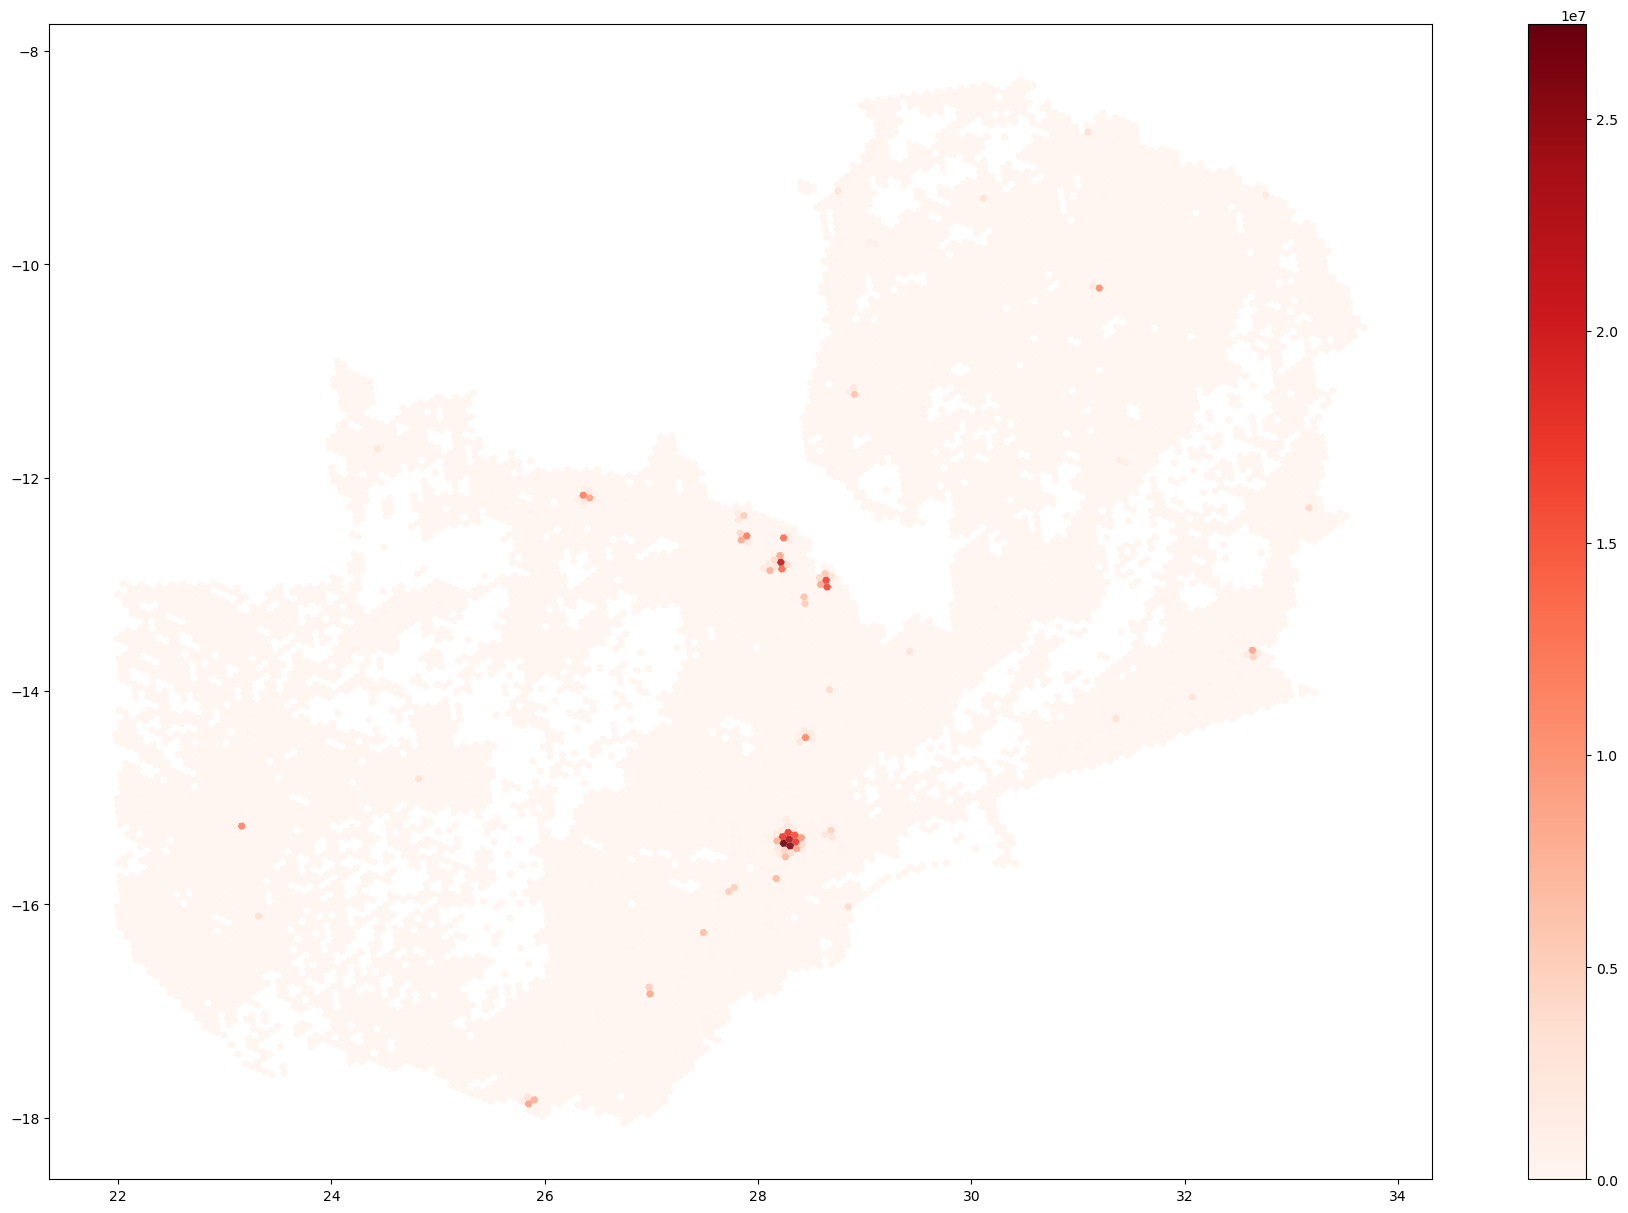

In [55]:
# Plot the energy consumption in services buildings map
# Create the axis first
fig, ax = plt.subplots(figsize=(25, 15))

# Plot data
grid.sort_values(config.COL_SER_ELEC_KWH_FINAL, ascending=True).plot(
    ax=ax, column=config.COL_SER_ELEC_KWH_FINAL, cmap="Reds", legend=True, alpha=0.9)

ax.set_aspect('equal', 'box')
# txt = ax.set_title('Services electricity consumption in {}'.format(area) )

# Save plot as figure 
plt.savefig(out_path + '/services_map' +str(alpha) +str(gama)+'.png', bbox_inches='tight')

In [ ]:
grid.to_csv(config.RESIDENTIAL_OUTPUT_DIR / 'dataser.csv')
grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / 'ser_energy_map.shp', index=False)
grid.to_file(config.RESIDENTIAL_OUTPUT_DIR / 'ser_energy_map.geojson', driver='GeoJSON', index=False)  
grid.head(3)

In [ ]:
total_servicesenergy_scaled = grid.groupby('NAME_1')[config.COL_SER_ELEC_KWH_FINAL].sum() 
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    total_servicesenergy_scaled[region] = total_servicesenergy_scaled[region]/10**6  # conversion in GWh
    print (region, f"{total_servicesenergy_scaled[region]:,.1f}", "GWh" )
print (total_servicesenergy_scaled )
print (total_servicesenergy_scaled.sum() )

In [ ]:
total_servicesenergy_scaled

# Buildings

In [ ]:
# total_Buienergy_scaled = total_servicesenergy_scaled + total_residentialenergy_scaled
total_Buienergy_scaled = total_servicesenergy_scaled + result_afterscaling['meth2']
print ("Services electricity consumption assessed after scaling:")
for region in regions:
    print (region, f"{total_Buienergy_scaled[region]:,.1f}", "GWh" )
print (total_Buienergy_scaled)